# Machine Learning Boilerplate Workflow (SVM Example)

## Define Problem

- Goal: Classify breast cancer tumors as malignant (0) or benign (1)
- Model: Support Vector Machine (SVM), supervised classification
- Why SVM? 
    - Works well for both linearly and non-linearly separable data
    - Robust to high-dimensional spaces
    - Uses "support vectors" (data points closest to the boundary) to define the decision boundary

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import joblib

## EDA

In [2]:
# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

print("Shape of dataset:", X.shape)
print("Class distribution:", np.bincount(y))
X.head()

Shape of dataset: (569, 30)
Class distribution: [212 357]


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%      

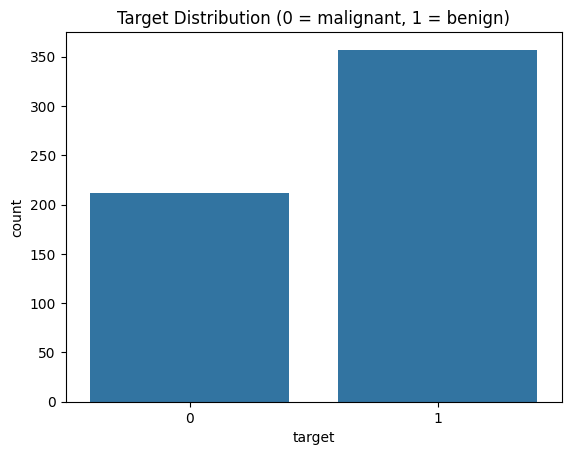

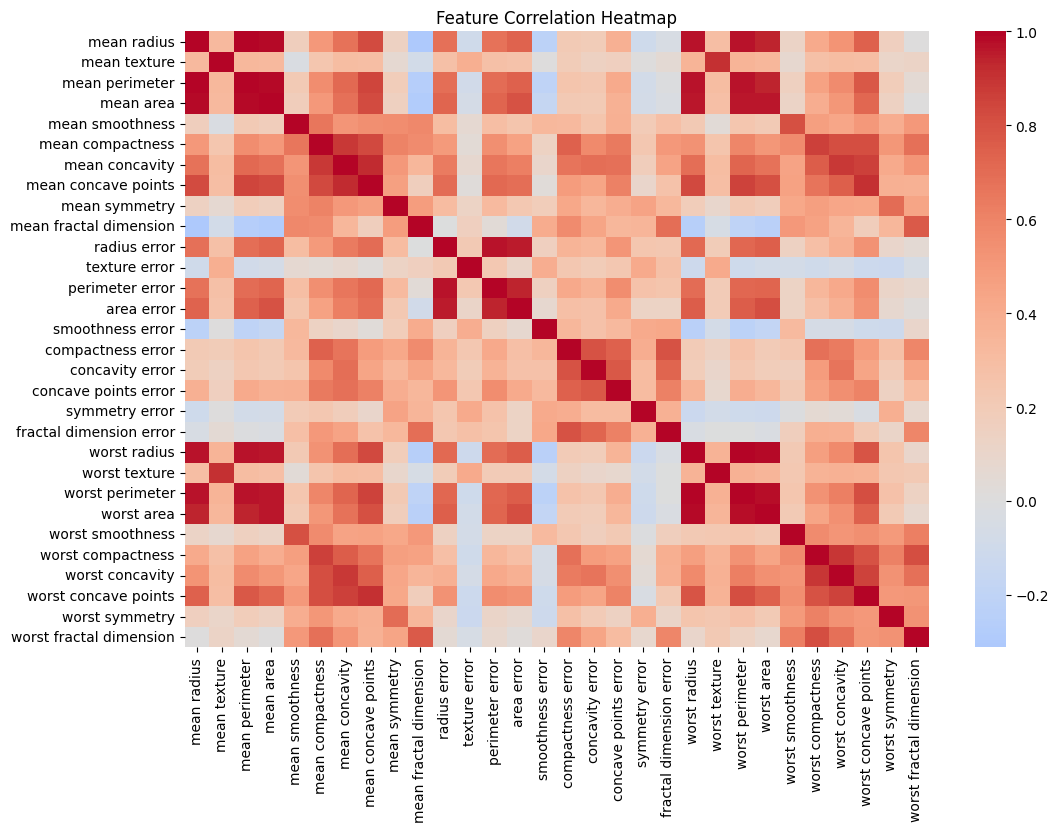

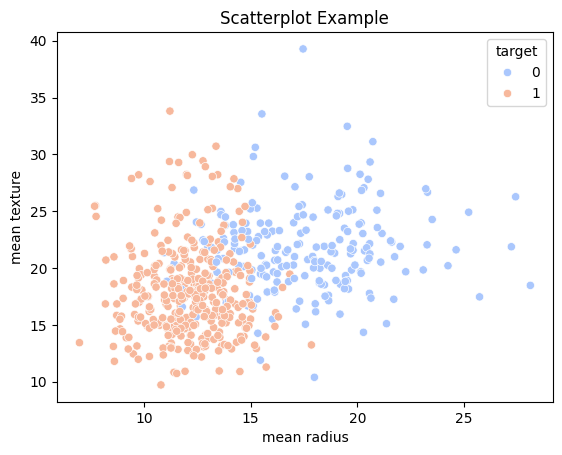

In [3]:
# Quick stats
print(X.describe())

# Target distribution
sns.countplot(x=y)
plt.title("Target Distribution (0 = malignant, 1 = benign)")
plt.show()

# Feature correlation
plt.figure(figsize=(12,8))
sns.heatmap(X.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# Pairwise scatter for two features
sns.scatterplot(x=X["mean radius"], y=X["mean texture"], hue=y, palette="coolwarm")
plt.title("Scatterplot Example")
plt.show()


## Data Preprocessing & Feature Engineering

SVM requires:
1. Scaling: because it uses distance-based kernels.
2. Feature engineering: try polynomial features for non-linear separation.

In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optional: add polynomial features (commented out here)
# poly = PolynomialFeatures(degree=2, interaction_only=False)
# X_train_scaled = poly.fit_transform(X_train_scaled)
# X_test_scaled = poly.transform(X_test_scaled)

## Baseline Model Training

Baseline Accuracy: 0.9736842105263158
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96        42
           1       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



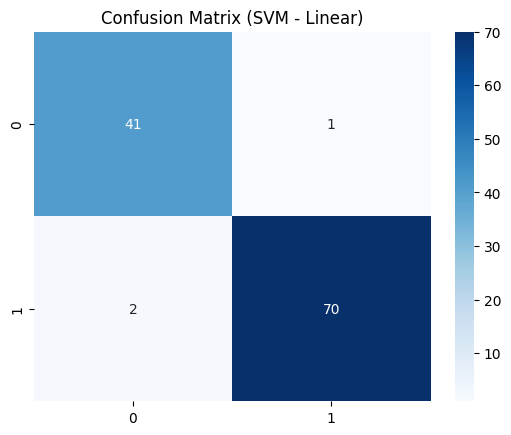

In [5]:
# Train a simple linear SVM
svm = SVC(kernel="linear", probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)

# Predictions
y_pred = svm.predict(X_test_scaled)

# Evaluation
print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (SVM - Linear)")
plt.show()

## Cross-Validation

In [6]:
cv_scores = cross_val_score(svm, X_train_scaled, y_train, cv=5, scoring="accuracy")
print("CV Accuracy (Linear SVM):", cv_scores.mean())

CV Accuracy (Linear SVM): 0.9670329670329669


## Grid Search with Hyperparameter Tuning

Key SVM Parameters

    1. C (regularization):
        - Small C → wider margin, allows misclassifications → high bias, low variance.
        - Large C → strict margin, fewer misclassifications → low bias, high variance (overfit).

    2. Kernel:
        - linear: simple linear separation.
        - rbf: radial basis function (non-linear).
        - poly: polynomial transformation.

    3. Gamma (for RBF/poly):
        - Low gamma → smooth, generalized boundary.
        - High gamma → very tight boundary, can overfit.

In [7]:
param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"]
}

grid = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_scaled, y_train)

print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV Score: 0.9802197802197803


## Model Evaluation, ROC & AUC

Tuned Accuracy: 0.9824561403508771
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



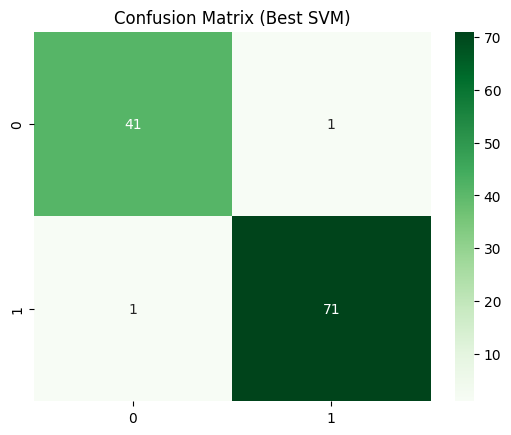

In [8]:
best_svm = grid.best_estimator_
y_pred_best = best_svm.predict(X_test_scaled)

print("Tuned Accuracy:", accuracy_score(y_test, y_pred_best))
print("Classification Report:\n", classification_report(y_test, y_pred_best))

sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix (Best SVM)")
plt.show()

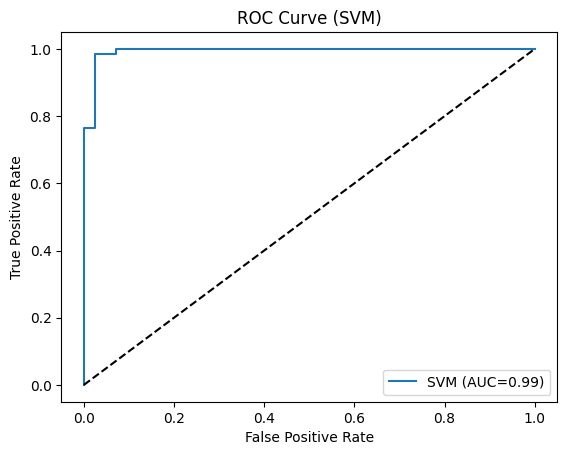

In [9]:
# ROC Curve
y_prob = best_svm.predict_proba(X_test_scaled)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"SVM (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (SVM)")
plt.legend()
plt.show()

## Bias Variance Trade Off

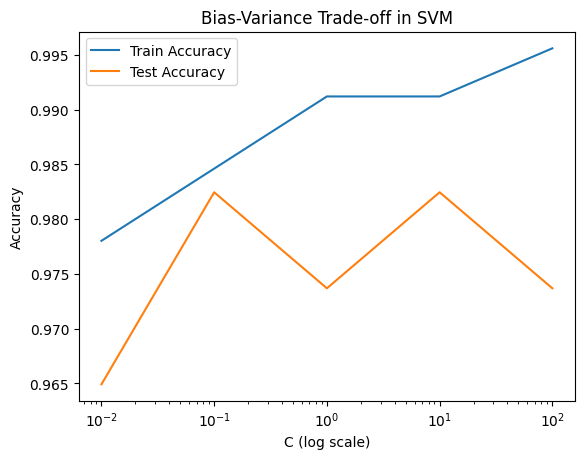

In [10]:
train_acc, test_acc = [], []
C_values = [0.01, 0.1, 1, 10, 100]

for c in C_values:
    svm_model = SVC(C=c, kernel="linear", probability=True, random_state=42)
    svm_model.fit(X_train_scaled, y_train)
    train_acc.append(svm_model.score(X_train_scaled, y_train))
    test_acc.append(svm_model.score(X_test_scaled, y_test))

plt.plot(C_values, train_acc, label="Train Accuracy")
plt.plot(C_values, test_acc, label="Test Accuracy")
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("Accuracy")
plt.title("Bias-Variance Trade-off in SVM")
plt.legend()
plt.show()

## Save Best Model

In [11]:
# Save best SVM
joblib.dump(best_svm, "svm_best_model.pkl")
print("Best SVM model saved as svm_best_model.pkl")

Best SVM model saved as svm_best_model.pkl


In [12]:
# Reload
loaded_svm = joblib.load("svm_best_model.pkl")
print("Loaded Model Accuracy:", accuracy_score(y_test, loaded_svm.predict(X_test_scaled)))

Loaded Model Accuracy: 0.9824561403508771
